In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *

/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [3]:
train_transforms = transforms.Compose([
                    transforms.Resize((112, 112)),
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.Resize((112, 112)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
epochs = 20
batch_size = 64
momentum = 0.9
lr = 0.0005
weight_decay = 1e-4
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = os.cpu_count()
saved = './cifar_timm_vit.pth'
timm_pretrained = '../saved/timm_vit.pth'

# pretrained_model = timm.create_model("vit_small_patch8_224.dino", pretrained=True)
pretrained_model = timm.create_model('vit_tiny_patch16_224.augreg_in21k', pretrained=True, num_classes=num_classes)
torch.save(pretrained_model.state_dict(), timm_pretrained)

In [6]:
# dir(pretrained_model)

In [7]:
# for name, param in pretrained_model.named_parameters():
#     print(param.requires_grad)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
images, targets = next(iter(train_loader))
images.shape, targets

(torch.Size([64, 3, 112, 112]),
 tensor([9, 6, 7, 6, 2, 7, 2, 3, 4, 5, 9, 4, 2, 8, 0, 8, 1, 6, 7, 5, 6, 9, 8, 0,
         6, 2, 1, 0, 9, 9, 2, 5, 0, 5, 3, 7, 6, 0, 5, 9, 3, 1, 5, 8, 9, 7, 6, 8,
         1, 4, 7, 7, 0, 9, 3, 2, 2, 0, 3, 4, 8, 0, 9, 7]))

In [10]:
model_args = dict(img_size=112, patch_size=16, embed_dim=192, depth=12, num_heads=2, checkpoint=timm_pretrained, qk_norm=False, v_norm=False)
model =  vit_small_patch8_32(**model_args)
# model.freeze('head')
# model.head = nn.Linear(model.embed_dim, num_classes)

load pretrained from ../saved/timm_vit.pth


In [11]:
out = model(images)
out.shape

torch.Size([64, 10])

In [12]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    

In [13]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


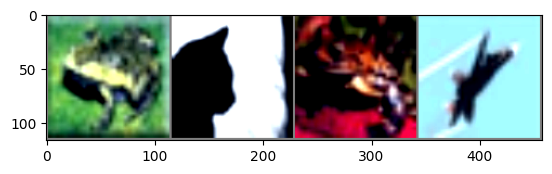

In [14]:
imshow(torchvision.utils.make_grid(images[:4]))

In [15]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr,
                            weight_decay=weight_decay)
scheduler = None

model = model.to(device)

# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# # scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, 
# #                                         step_size_down=None, mode='exp_range', gamma=0.995)
# from utils.scheduler import CosineAnnealingWarmUpRestarts
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=20, T_mult=1, eta_max=0.1,  T_up=5, gamma=0.5)

# model = model.to(device)

In [16]:
from utils.metric import get_acc

In [17]:
best_acc = 0.
val_acc_list = []
for epoch in (range(epochs)):
    running_loss = []
    model.train()
    for i, data in (enumerate(train_loader)):
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    test_acc = get_acc(test_loader, model, device)
    val_acc_list.append(test_acc)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), saved)

    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} loss: {sum(running_loss)/len(running_loss):.3f} acc: {test_acc:.2f} lr: {lr:.5f}')
    if scheduler :
        scheduler.step()


1 loss: 1.140 acc: 72.33 lr: 0.00050
2 loss: 0.700 acc: 76.89 lr: 0.00050
3 loss: 0.577 acc: 81.00 lr: 0.00050
4 loss: 0.500 acc: 80.78 lr: 0.00050
5 loss: 0.452 acc: 81.28 lr: 0.00050
6 loss: 0.412 acc: 81.18 lr: 0.00050
7 loss: 0.385 acc: 82.06 lr: 0.00050
8 loss: 0.361 acc: 83.84 lr: 0.00050
9 loss: 0.336 acc: 85.00 lr: 0.00050
10 loss: 0.318 acc: 84.70 lr: 0.00050
11 loss: 0.291 acc: 83.98 lr: 0.00050
12 loss: 0.282 acc: 84.44 lr: 0.00050
13 loss: 0.269 acc: 84.36 lr: 0.00050



KeyboardInterrupt

